In [1]:
import numpy as np
import pandas as pd
import SAGA
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

from SAGA import ObjectCuts as C

In [2]:
# Data manipulations

def get_radii(coordinates):
    radii = []
    for coordinate_pair in coordinates:
        radii.append(np.sqrt(coordinate_pair[0]**2+coordinate_pair[1]**2))
    return radii
    
def get_ellipticities(coordinates):
    # # First get quadrupole moments
    coordinates_squared = np.square(coordinates)

    xdiff_ydiff_col = np.prod(coordinates, axis=2)
    xdiff_ydiff_col = xdiff_ydiff_col[:,:,np.newaxis]

    quadrupole_moments_setup = np.insert(coordinates_squared, 0, [[[xdiff_ydiff_col]]], axis=2) # diffx*diffy now at position 0
    quadrupole_moments = quadrupole_moments_setup.mean(axis=1)

    # # Get ellipticity from quadrupole moments
    # Q_xy, Q_xx, Q_yy = np.quadrupole_moments
    quadrupole_xx_yy = quadrupole_moments[:,1:3]
    quadrupole_xy = quadrupole_moments[:,0:1]

    e_1_numerator = -np.diff(quadrupole_xx_yy, axis=1)
    e_2_numerator = 2*quadrupole_xy

    e_denominator_1 = np.sum(quadrupole_xx_yy, axis=1)[:,np.newaxis]
    e_denominator_inside_sqrt = np.prod(quadrupole_xx_yy, axis=1)[:,np.newaxis] - quadrupole_xy**2
    e_denominator = e_denominator_1 + 2*np.sqrt(e_denominator_inside_sqrt)

    e_1 = e_1_numerator / e_denominator
    e_2 = e_2_numerator / e_denominator

    ellipticities = np.sqrt(e_1**2 + e_2**2)[:,0]

    return ellipticities


def get_randomized_ellipticities(radii, num_repititions):
    num = len(radii)
    radial_stdev = np.std(radii)

    # Create "isotropic" (random from uniform - not uniform) angles
    coords = np.random.randn(num_repititions, num, 2)  # (number of times to repeat data set generation, how many satellites, how many spatial dimensions)
    calc_radii = np.sqrt((coords**2).sum(axis=2))
    normalized_coords = coords/calc_radii[:,:,np.newaxis]

    # Move the positions of satellites out or in radially until they reach original radial scale
    reshaped_radii = np.reshape(radii, (1,len(radii), 1))
    scaled_coords = normalized_coords*reshaped_radii

    ellipticities = get_ellipticities(scaled_coords,)
    
    return ellipticities


def get_prominence(actual, radii, num_repititions):
    randomized = get_randomized_ellipticities(radii, num_repititions)
    abv_actual = np.where(randomized > actual, 1, 0)
    p_above_actual = np.sum(abv_actual)/num_repititions
    prominence = 1/p_above_actual
    
    return prominence

In [3]:
# Dataframe manipulations
def filter_subhalo_dataframe_by_num_satellites(cutoff):
    filtered_dataframe = VSMDPL_subs_raw[VSMDPL_subs_raw['vmax_mpeak'] >= cutoff].copy()
    filtered_dataframe = filtered_dataframe.groupby(['HOSTID']).filter(lambda x: len(x) > 2).copy()
    return filtered_dataframe

def add_coordinate_columns(dataframe):
    dataframe['x_coord'] = dataframe['x_adj'] - dataframe['x_host']
    dataframe['y_coord'] = dataframe['y_adj'] - dataframe['y_host']
    # dataframe['z_coord'] = dataframe['z_adj'] - dataframe['z_host']
    # dataframe['3d_coordinates'] = dataframe[['x_coord', 'y_coord', 'z_coord']].values.tolist()
    dataframe['2d_coordinates'] = dataframe[['x_coord', 'y_coord']].values.tolist()

def get_systems_dataframe(dataframe):
    systems_df = dataframe.groupby('HOSTID')['2d_coordinates'].apply(tuple).reset_index(name='coordinates_list')
    systems_df['coordinates_list'] = systems_df['coordinates_list'].tolist()
    systems_df['radii'] = systems_df['coordinates_list'].apply(get_radii)
    return systems_df

def add_ellipticity_columns(dataframe):
    dataframe['ellipticity_actual'] = dataframe.apply(lambda x: get_ellipticities([x['coordinates_list']])[0], axis=1)
    dataframe['ellipticity_isotropic'] = dataframe.apply(lambda x: get_randomized_ellipticities(x['radii'], 1)[0], axis=1)

def add_num_subs_column(dataframe):
    dataframe['num_subs'] = dataframe['radii'].str.len()
    display(dataframe)

def add_prominence_columns(dataframe, num_iterations):
    dataframe['prominence'] = dataframe.apply(lambda x: get_prominence(x['ellipticity_actual'], x['radii'], num_iterations), axis=1)
    dataframe['prominence_isotropic'] = dataframe.apply(lambda x: get_prominence(x['ellipticity_isotropic'], x['radii'], num_iterations), axis=1)

def get_plot_data(dataframe):
    data_act = pd.DataFrame(dataframe['prominence'])
    data_act['Dataset'] = 'Actual'
    data_iso = pd.DataFrame(dataframe['prominence_isotropic']).rename(columns={"prominence_isotropic": "prominence"})
    data_iso['Dataset'] = 'Isotropic'
    plot_data = pd.concat([data_act,data_iso], ignore_index=True)
    return plot_data

def plot_prominence(data, num_iterations):
    format = {
        "figure.facecolor": "212946",
        "axes.facecolor": "212946",
        "savefig.facecolor": "212946", 
        "grid.color": "2A3459",
        "text.color": "0.9",
        "axes.labelcolor": "0.9",
        "xtick.color": "0.9",
        "ytick.color": "0.9",
        "grid.linestyle": "-",
        "lines.solid_capstyle": "round",
        "figure.figsize" : "(11.7,8.27)"
    }

    sns.set_style("darkgrid", format)

    fig, ax1 = plt.subplots()
    sp1 = sns.ecdfplot(data=data, x="prominence", hue="Dataset", hue_order=['Actual', 'Isotropic'], complementary=True, ax=ax1)
    ax1.set_xscale('log')
    ax1.set_xlim(1,num_iterations)

In [4]:
def get_ellipticity_and_prominence_data(dataframe, num_iterations):
    add_coordinate_columns(dataframe)
    systems_dataframe = get_systems_dataframe(dataframe).copy()
    add_ellipticity_columns(systems_dataframe)
    add_prominence_columns(systems_dataframe, num_iterations) # bottleneckyy
    plot_data = get_plot_data(systems_dataframe).copy()
    return [systems_dataframe, plot_data]

## Get Data

In [5]:
# from SAGA-halo-ellipticities (filtered + cartesian coords)
%store -r

iterations = 10000

# Apples to apples these bad boys
VSMDPL_subs_raw.rename(columns = {'upid':'HOSTID'}, inplace = True)
saga_sats.rename(columns = {'X':'x_adj', 'Y':'y_adj', 'HOST_X':'x_host', 'HOST_Y':'y_host'}, inplace = True)

# Use vmax_mpeak as proxy for luminosity
vmax_cutoff_for_avg_num = {
    '3.5' : 61,
      '4' : 51.6,
    '4.5' : 46.4,
      '5' : 43.5,
    '5.5' : 40.98,
    'saga': 44.09 # 4.855 sats per host on average
}

VSMDPL_subs_multi = {}
for cutoff in list(vmax_cutoff_for_avg_num.keys())[:5]:
    VSMDPL_subs_multi[cutoff] = filter_subhalo_dataframe_by_num_satellites(vmax_cutoff_for_avg_num[cutoff])
VSMDPL_subs = filter_subhalo_dataframe_by_num_satellites(vmax_cutoff_for_avg_num['saga'])
saga_sats = saga_sats.groupby(['HOSTID']).filter(lambda x: len(x) > 2).copy()

## SAGA Analysis

,HOSTID,coordinates_list,radii,ellipticity_actual,ellipticity_isotropic,prominence,prominence_isotropic
0,nsa126115,"([-0.0020247927082452113, 0.008711667929781064...","[0.008943877438233312, 0.0012570650928419062, ...",0.594528,0.725373,1.260081,2.876870
1,nsa127226,"([0.005553228030597074, 0.002269217403307905],...","[0.005998974010885905, 0.010283718519436004, 0...",0.536252,0.440330,11.074197,4.909180
2,nsa129237,"([-0.0020121298570342666, 0.002820599407806601...","[0.0034647435086724225, 0.0008636769851017844,...",0.286774,0.471705,1.085776,2.695418
3,nsa130133,"([-0.004797112631803922, -0.000940569312737060...","[0.004888451721585825, 0.008755640580899112, 0...",0.631965,0.129427,9.920635,1.211827
4,nsa133115,"([-0.0020419430153951145, -0.00457139672365330...","[0.005006715418630172, 0.0010109396589111578, ...",0.301248,0.437869,1.975504,4.852014
...,...,...,...,...,...,...,...
64,pgc67817,"([-0.0028500985388926516, 0.001457866082313908...","[0.003201317727961305, 0.006162889826653651, 0...",0.282646,0.147738,4.496403,1.507386
65,pgc68312,"([-0.0009163517156564263, 0.000918607745225452...","[0.0012975132586508186, 0.007369575481277809, ...",0.134362,0.264070,1.254233,2.331002
66,pgc69677,"([-0.002819107201387551, 0.003292271170450251]...","[0.004334329806635971, 0.0076545744461821675, ...",0.536936,0.122544,5.678592,1.184273
67,pgc72060,"([-0.003315844065320208, 0.0011990837164039814...","[0.00352599257294516, 0.005651237789069938, 0....",0.235636,0.390116,1.090750,2.098636


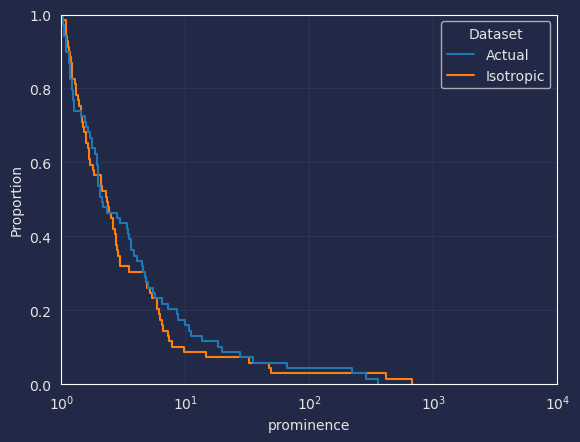

In [6]:
saga_data, saga_plot = get_ellipticity_and_prominence_data(saga_sats, iterations)
plot_prominence(saga_plot, iterations)
saga_data
# saga_data

#### Generate 100x isotropic data

## SIM Analysis

In [ ]:
VSMDPL_data, VSMDPL_plot = get_ellipticity_and_prominence_data(VSMDPL_subs, iterations)
plot_prominence(VSMDPL_plot, iterations)
# VSMDPL_data


## SAGA + SIM

In [ ]:
saga_plot['Datasource'] = 'Saga'
VSMDPL_plot['Datasource'] = 'VSMDPL'
saga_sim_data = pd.concat([saga_plot, VSMDPL_plot], ignore_index=True)

fig, ax1 = plt.subplots()
sp1 = sns.ecdfplot(data=saga_sim_data, x="prominence", hue=saga_sim_data[['Datasource', 'Dataset']].apply(tuple, axis=1), complementary=True, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlim(1,10000)

# generate more than 1 isotropic data points for saga so we can smooth orange data plot

In [ ]:
saga_data['Datasource'] = 'Saga'
VSMDPL_data['Datasource'] = 'VSMDPL'
saga_sim_ellipticity_data = pd.concat([saga_data, VSMDPL_data], ignore_index=True)

fig, ax1 = plt.subplots()
ax1.set_xlabel('$\longleftarrow$ more spherical         Ellipticity (2D)         more elliptical $\longrightarrow$')
sp1 = sns.histplot(saga_sim_ellipticity_data, x="ellipticity_actual", hue="Datasource", hue_order=['Saga', 'VSMDPL'], bins=7, element="poly", stat="density", common_norm=False, common_bins=True, fill=False, ax=ax1, palette='viridis')

## SIM Compare prominence for different avg # satellites

In [ ]:
VSMDPL_systems_multi = {}
VSMDPL_plot_multi = {}

for avg in list(vmax_cutoff_for_avg_num.keys())[:5]:
    VSMDPL_systems_multi[avg], VSMDPL_plot_multi[avg] = get_ellipticity_and_prominence_data(VSMDPL_subs_multi[avg], iterations)
    VSMDPL_plot_multi[avg]['Average # Satellites'] = avg
    VSMDPL_systems_multi[avg]['Datasource'] = 'VSMDPL ' + avg

In [ ]:
VSMDPL_multi_plot_data = pd.concat(VSMDPL_plot_multi, ignore_index=True)
VSMDPL_multi_plot_data = VSMDPL_multi_plot_data[VSMDPL_multi_plot_data['Dataset'] == 'Actual'].copy()

fig, ax1 = plt.subplots()
sp1 = sns.ecdfplot(data=VSMDPL_multi_plot_data, x="prominence", hue='Average # Satellites', hue_order=['3.5', '4', '4.5', '5', '5.5'], complementary=True, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlim(1,iterations)

In [ ]:
for df in VSMDPL_systems_multi.values():
    add_num_subs_column(df)

In [ ]:
VSMDPL_multi_data = pd.concat(VSMDPL_systems_multi, ignore_index=True)
fig, ax1 = plt.subplots()
ax1.set_xlabel('$\longleftarrow$ more spherical         Ellipticity (2D)         more elliptical $\longrightarrow$')
sp1 = sns.histplot(VSMDPL_multi_data, x="ellipticity_actual", hue="Datasource", hue_order=['VSMDPL 3.5', 'VSMDPL 4', 'VSMDPL 4.5', 'VSMDPL 5', 'VSMDPL 5.5'], bins=7, element="poly", stat="density", common_norm=False, common_bins=True, fill=False, ax=ax1, palette='viridis')

In [ ]:
all_data = pd.concat([VSMDPL_multi_data, saga_sim_ellipticity_data], ignore_index=True)

fig, ax1 = plt.subplots()
ax1.set_xlabel('$\longleftarrow$ more spherical         Ellipticity (2D)         more elliptical $\longrightarrow$')
sp1 = sns.histplot(all_data, x="ellipticity_actual", hue="Datasource", hue_order=['Saga', 'VSMDPL', 'VSMDPL 3.5', 'VSMDPL 4', 'VSMDPL 4.5', 'VSMDPL 5', 'VSMDPL 5.5'], bins=7, element="poly", stat="density", common_norm=False, common_bins=True, fill=False, ax=ax1, palette='viridis')